Research Paper: https://arxiv.org/abs/1904.05068

2019 paper

Dataset: CIFAR 100

Code Link: https://github.com/lenscloth/RKD




In [28]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np


In [29]:
# Dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

# Models
teacher = models.resnet18(pretrained=True)
student = models.resnet18(pretrained=False)


Files already downloaded and verified


In [30]:


class RKDLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(RKDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, student, teacher):
        d_student = student.unsqueeze(0) - student.unsqueeze(1)
        d_teacher = teacher.unsqueeze(0) - teacher.unsqueeze(1)

        d_student = d_student.norm(p=2, dim=2)
        d_teacher = d_teacher.norm(p=2, dim=2)

        dist_loss = F.mse_loss(d_student, d_teacher)

        angle_student = torch.acos(F.cosine_similarity(student.unsqueeze(0), student.unsqueeze(1), dim=2))
        angle_teacher = torch.acos(F.cosine_similarity(teacher.unsqueeze(0), teacher.unsqueeze(1), dim=2))

        angle_loss = F.mse_loss(angle_student, angle_teacher)

        return self.alpha * dist_loss + self.beta * angle_loss


In [31]:
criterion = RKDLoss()
optimizer = torch.optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)


In [32]:
losses = []
accuracies = []

# Modified Training Loop
epochs = 15   # 40 - this was defatul
for epoch in range(epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in trainloader:
        optimizer.zero_grad()

        student_outputs = student(inputs)
        teacher_outputs = teacher(inputs).detach()

        loss = criterion(student_outputs, teacher_outputs)
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        _, predicted = student_outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()
    avg_loss = epoch_loss / len(trainloader)
    acc = 100 * correct / total

    losses.append(avg_loss)
    accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

Epoch [1/15], Loss: nan, Accuracy: 9.98%
Epoch [2/15], Loss: nan, Accuracy: 10.00%
Epoch [3/15], Loss: nan, Accuracy: 10.00%
Epoch [4/15], Loss: nan, Accuracy: 10.00%
Epoch [5/15], Loss: nan, Accuracy: 10.00%
Epoch [6/15], Loss: nan, Accuracy: 10.00%
Epoch [7/15], Loss: nan, Accuracy: 10.00%
Epoch [8/15], Loss: nan, Accuracy: 10.00%
Epoch [9/15], Loss: nan, Accuracy: 10.00%
Epoch [10/15], Loss: nan, Accuracy: 10.00%
Epoch [11/15], Loss: nan, Accuracy: 10.00%
Epoch [12/15], Loss: nan, Accuracy: 10.00%
Epoch [13/15], Loss: nan, Accuracy: 10.00%
Epoch [14/15], Loss: nan, Accuracy: 10.00%
Epoch [15/15], Loss: nan, Accuracy: 10.00%


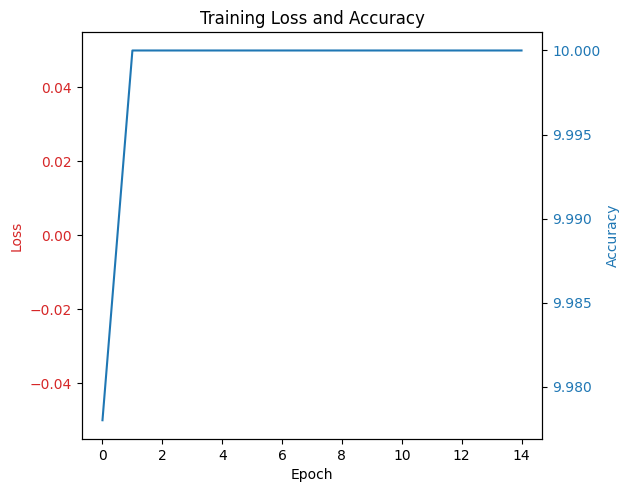

In [33]:

# Plotting
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(epochs), losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(np.arange(epochs), accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training Loss and Accuracy')
plt.show()


### Testing:
The accuray and loss outputs seem wrong

In [34]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

# Models
teacher = models.resnet18(pretrained=True)
student = models.resnet18(pretrained=False)


Files already downloaded and verified


In [35]:
# Criterion
class RKDLoss(torch.nn.Module):
    def __init__(self):
        super(RKDLoss, self).__init__()

    def forward(self, student, teacher):
        student_pairwise_dist = torch.norm(student[:, :, None] - student[:, None, :], dim=0)
        teacher_pairwise_dist = torch.norm(teacher[:, :, None] - teacher[:, None, :], dim=0)

        loss = F.mse_loss(student_pairwise_dist, teacher_pairwise_dist)
        return loss

In [36]:


criterion = RKDLoss()
optimizer = torch.optim.SGD(student.parameters(), lr=0.01)

train_losses = []
accuracies = []

epochs = 10  # default was 40 and tested upto 200
for epoch in range(epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()

        student_outputs = student(inputs)
        teacher_outputs = teacher(inputs).detach()

        loss = criterion(student_outputs, teacher_outputs)
        loss.backward()

        optimizer.step()

        # Compute accuracy
        _, predicted = torch.max(student_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(trainloader))
    accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_losses[-1]:.4f}, Accuracy: {accuracies[-1]:.2f}%")


Epoch [1/10], Loss: 84.8212, Accuracy: 0.24%
Epoch [2/10], Loss: 39.5185, Accuracy: 0.46%
Epoch [3/10], Loss: 33.9865, Accuracy: 0.54%
Epoch [4/10], Loss: 30.4543, Accuracy: 0.71%
Epoch [5/10], Loss: 29.0182, Accuracy: 0.59%
Epoch [6/10], Loss: 27.4922, Accuracy: 0.48%
Epoch [7/10], Loss: 26.5295, Accuracy: 0.42%
Epoch [8/10], Loss: 25.6975, Accuracy: 0.36%
Epoch [9/10], Loss: 24.7716, Accuracy: 0.40%
Epoch [10/10], Loss: 24.4760, Accuracy: 0.48%


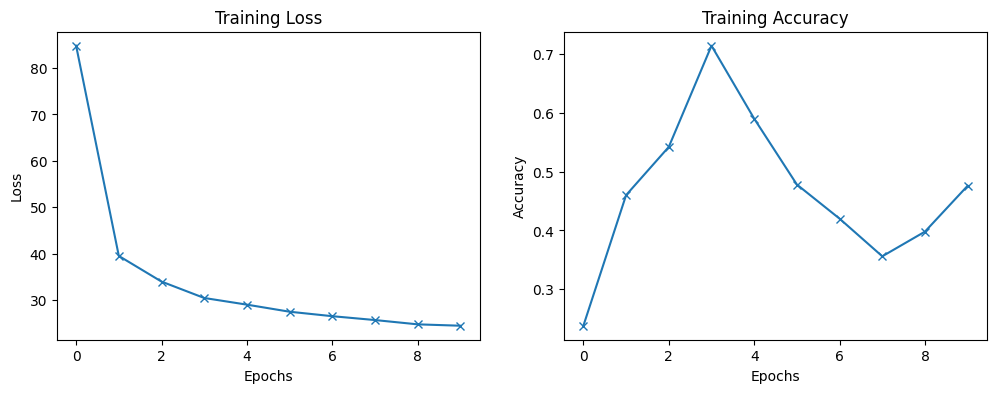

In [37]:
# Plotting the training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-x')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plotting the training accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, '-x')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
